In [2]:
# combine sentiment by stanford
import pandas as pd
import numpy as np
df = pd.read_csv('sentiment_tweet.csv', quotechar='"')
del df['text']
del df['Unnamed: 0']
del df['Unnamed: 0.1']
del df['user']

import ast

def getSent(row):
    sentiment = ast.literal_eval(row['sentiment'])['sentiment']
    stanford = row['stanford']
    if stanford == 1:
        stanford = 1
    if stanford == -1:
        stanford = -1
    if stanford == 2:
        stanford = 1
    if stanford == -2:
        stanford = -1
    if sentiment == None:
        return stanford
    else:
        if sentiment['basic'] == 'Bullish':
            return 2
        if sentiment['basic'] == 'Bearish':
            return -2
        return stanford
    
df['sentiment'] = df.apply(getSent, axis=1)
del df['stanford']
df.head()
df['sentiment'].value_counts()

-1    81348
 2    63777
 0    41912
-2    25351
 1    10588
Name: sentiment, dtype: int64

In [3]:
# aggregate by date
def getIndex(arr):
    bull = 0
    bear = 0
    for i in arr:
        if i > 0:
            bull += i
        if i < 0:
            bear += -i
#     return bull-bear
    if bull == bear:
        return 0
    elif bull > bear:
        return ((2*bull)/(bull+bear) - 1) / len(arr)
    else:
        return (1 - (2*bear)/(bull+bear)) / len(arr)

data = df.groupby('date').agg({'sentiment': getIndex})['sentiment']
data.to_csv('aggregate_tweet.csv')

In [2]:
#add time series to sentiment
import pandas as pd
import numpy as np
import datetime as dt
df = pd.read_csv("./AAP_data.csv", usecols=[0,1,2,3,4,5])
df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x,"%Y-%m-%d").strftime('%Y.%m.%d'))

data = pd.read_csv('./aggregate_tweet.csv', header=None, names = ['date', 'sentiment'])
data = data.set_index('date')
df = df.set_index('date')
result = pd.concat([data, df], axis=1, join='inner')
result.to_csv('./merged_result.csv')
result = pd.read_csv('./merged_result.csv', usecols=[1,5,6])
result.head()

result['output'] = result.close.shift(-1)    

print(result.head())

result.dropna(inplace=True)
result.reset_index(drop=True,inplace=True)
try:
    result = result.drop(columns=['date'])
except:
    pass

   sentiment     close   volume    output
0  -0.005629  116.4330  1354443  115.6743
1  -0.000106  115.6743   813029  114.0570
2  -0.000549  114.0570   636041  115.0454
3  -0.000074  115.0454   689637  111.5795
4   0.000004  111.5795  1042421  110.7105


In [3]:
#preprocess dataframe

result['output'] = result.apply(lambda row: -100 if row['output'] - row['close'] < 0 else 100, axis=1)
# result['output'] = result.apply(lambda row['output'] - row['close'], axis=1)
print(result.head())
def norm(a):
    b = a - a.min()
    b /= b.max()
    b *= 2
    b -= 1
#     b *= 100
    return b

result['sentiment'] = norm(result['sentiment'])
# result['output'] = norm(result['output'])
result['close'] = norm(result['close'])
result['volume'] = norm(result['volume'])
result.to_csv('./ML_cols.csv', encoding='utf-8')
result.head()

   sentiment     close   volume  output
0  -0.005629  116.4330  1354443    -100
1  -0.000106  115.6743   813029    -100
2  -0.000549  114.0570   636041     100
3  -0.000074  115.0454   689637    -100
4   0.000004  111.5795  1042421    -100


,sentiment,close,volume,output
0,-1.000000,-0.684134,-0.505641,-100
1,0.694660,-0.702865,-0.765822,-100
2,0.558816,-0.742793,-0.850875,100
3,0.704446,-0.718391,-0.825119,-100
4,0.728448,-0.803958,-0.655585,-100


In [5]:
#fit model

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back-1, len(dataset)):
        a = []
        for j in range(look_back):
            a += dataset[i-j, :-1].tolist()
        dataX.append(a)
        dataY.append(dataset[i, -1])
    return numpy.array(dataX), numpy.array(dataY)

numpy.random.seed(7)

dataframe = pd.read_csv('./ML_cols.csv', usecols=[1,2,3,4])
dataset = dataframe.values
dataset = dataset.astype('float32')
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

model = Sequential()
model.add(LSTM(input_shape=(3 * look_back, trainX.shape[2]), units=100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
batch_size=20
model.fit(trainX, trainY, epochs=500, batch_size=batch_size, verbose=2)


Epoch 1/500
 - 1s - loss: 9998.1576
Epoch 2/500
 - 0s - loss: 9991.9657
Epoch 3/500
 - 0s - loss: 9979.1176
Epoch 4/500
 - 0s - loss: 9889.7982
Epoch 5/500
 - 0s - loss: 9725.4449
Epoch 6/500
 - 0s - loss: 9675.9680
Epoch 7/500
 - 0s - loss: 9651.7083
Epoch 8/500
 - 0s - loss: 9635.5257
Epoch 9/500
 - 0s - loss: 9618.4186
Epoch 10/500
 - 0s - loss: 9612.8658
Epoch 11/500
 - 0s - loss: 9609.6279
Epoch 12/500
 - 0s - loss: 9607.1403
Epoch 13/500
 - 0s - loss: 9603.3339
Epoch 14/500
 - 0s - loss: 9601.4407
Epoch 15/500
 - 0s - loss: 9600.6523
Epoch 16/500
 - 0s - loss: 9597.6632
Epoch 17/500
 - 0s - loss: 9597.9170
Epoch 18/500
 - 0s - loss: 9595.9154
Epoch 19/500
 - 0s - loss: 9596.3522
Epoch 20/500
 - 0s - loss: 9594.8480
Epoch 21/500
 - 0s - loss: 9593.3049
Epoch 22/500
 - 0s - loss: 9592.2250
Epoch 23/500
 - 0s - loss: 9591.3005
Epoch 24/500
 - 0s - loss: 9590.2313
Epoch 25/500
 - 0s - loss: 9589.0573
Epoch 26/500
 - 0s - loss: 9588.8183
Epoch 27/500
 - 0s - loss: 9588.1766
Epoch 28/5

Epoch 220/500
 - 0s - loss: 9578.8759
Epoch 221/500
 - 0s - loss: 9578.6004
Epoch 222/500
 - 0s - loss: 9579.2926
Epoch 223/500
 - 0s - loss: 9580.5309
Epoch 224/500
 - 0s - loss: 9578.7136
Epoch 225/500
 - 0s - loss: 9579.0174
Epoch 226/500
 - 0s - loss: 9579.2783
Epoch 227/500
 - 0s - loss: 9578.5571
Epoch 228/500
 - 0s - loss: 9578.7956
Epoch 229/500
 - 0s - loss: 9579.3993
Epoch 230/500
 - 0s - loss: 9578.6397
Epoch 231/500
 - 0s - loss: 9579.1031
Epoch 232/500
 - 0s - loss: 9579.1157
Epoch 233/500
 - 0s - loss: 9579.5232
Epoch 234/500
 - 0s - loss: 9578.5273
Epoch 235/500
 - 0s - loss: 9579.4844
Epoch 236/500
 - 0s - loss: 9578.8631
Epoch 237/500
 - 0s - loss: 9579.0935
Epoch 238/500
 - 0s - loss: 9578.6956
Epoch 239/500
 - 0s - loss: 9578.7985
Epoch 240/500
 - 0s - loss: 9578.8651
Epoch 241/500
 - 0s - loss: 9579.0143
Epoch 242/500
 - 0s - loss: 9578.8752
Epoch 243/500
 - 0s - loss: 9578.7331
Epoch 244/500
 - 0s - loss: 9578.6130
Epoch 245/500
 - 0s - loss: 9579.2490
Epoch 246/50

Epoch 436/500
 - 0s - loss: 9578.9347
Epoch 437/500
 - 0s - loss: 9578.8782
Epoch 438/500
 - 0s - loss: 9579.2385
Epoch 439/500
 - 0s - loss: 9579.1180
Epoch 440/500
 - 0s - loss: 9579.8172
Epoch 441/500
 - 0s - loss: 9578.6349
Epoch 442/500
 - 0s - loss: 9578.6615
Epoch 443/500
 - 0s - loss: 9578.6103
Epoch 444/500
 - 0s - loss: 9578.7343
Epoch 445/500
 - 0s - loss: 9578.8614
Epoch 446/500
 - 0s - loss: 9579.2042
Epoch 447/500
 - 0s - loss: 9581.1065
Epoch 448/500
 - 0s - loss: 9579.6723
Epoch 449/500
 - 0s - loss: 9579.0356
Epoch 450/500
 - 0s - loss: 9579.1426
Epoch 451/500
 - 0s - loss: 9578.7287
Epoch 452/500
 - 0s - loss: 9580.4657
Epoch 453/500
 - 0s - loss: 9579.3009
Epoch 454/500
 - 0s - loss: 9578.5907
Epoch 455/500
 - 0s - loss: 9578.7811
Epoch 456/500
 - 0s - loss: 9578.6409
Epoch 457/500
 - 0s - loss: 9578.8098
Epoch 458/500
 - 0s - loss: 9579.2627
Epoch 459/500
 - 0s - loss: 9579.1563
Epoch 460/500
 - 0s - loss: 9578.7643
Epoch 461/500
 - 0s - loss: 9579.3033
Epoch 462/50

In [6]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

trainCorrect = trainY
testCorrect = testY

import math

def sign(a):
    if a>0:
        return 1
    if a<0:
        return -1
    return 0

def acc(a, b):
    cnt = 0
    for i in range(len(a)):
        print(a[i], b[i])
        if sign(a[i]) == sign(b[i]):
            cnt += 1
#     return
    return cnt / len(a)

trainScore = math.sqrt(mean_squared_error(trainCorrect[:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print()
print("acc: ", acc((trainCorrect[:]), (trainPredict[:,0])))
print()
print()
print()
testScore = math.sqrt(mean_squared_error(testCorrect[:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print()
print("acc: ", acc((testCorrect[:]), (testPredict[:,0])))


Train Score: 97.87 RMSE

-100.0 20.498732
100.0 20.498817
100.0 20.498848
100.0 20.498837
100.0 20.49878
-100.0 20.498774
-100.0 20.498787
100.0 20.498724
100.0 20.498781
-100.0 20.498823
-100.0 20.498695
100.0 20.498707
-100.0 20.498812
-100.0 20.49881
-100.0 20.498741
-100.0 20.498816
100.0 20.498798
-100.0 20.498856
-100.0 20.498812
-100.0 20.498703
100.0 20.498795
100.0 20.498749
100.0 20.498741
100.0 20.498705
100.0 20.498775
-100.0 20.498781
100.0 20.49876
100.0 20.498783
-100.0 20.49868
100.0 20.498764
-100.0 20.49878
100.0 20.49882
100.0 20.49877
100.0 20.498833
100.0 20.49881
100.0 20.49884
-100.0 20.498774
-100.0 20.498713
100.0 20.498854
-100.0 20.49873
100.0 20.498798
-100.0 20.498806
100.0 20.498804
100.0 20.498772
-100.0 20.49877
-100.0 20.498705
100.0 20.498413
100.0 20.498629
-100.0 20.498741
100.0 20.498756
100.0 20.498758
100.0 20.498749
-100.0 20.498697
100.0 20.498783
100.0 20.498783
100.0 20.498806
-100.0 20.498756
100.0 20.498703
100.0 20.498808
100.0 20.498802
10

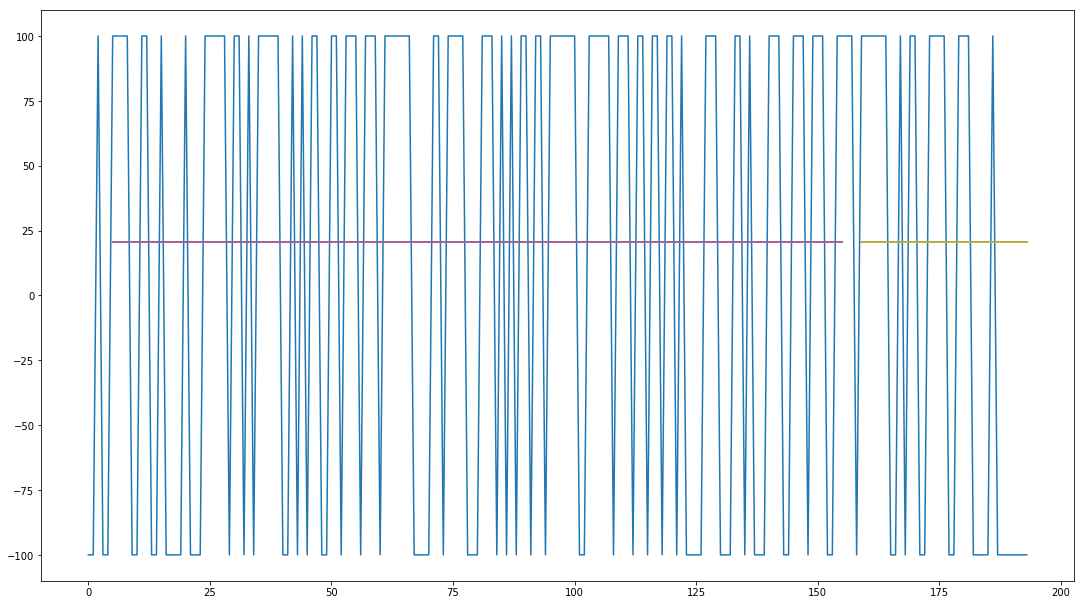

In [7]:
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)-2:len(dataset), :] = testPredict

plt.plot((dataframe['output']))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()